# Let's build a bootstrap particle filter (with ancestor resampling) 

In [1]:
from particle_filter import *

# Bayesian inference

Suppose you're at a basketball game and you observe a ball flying through the air into a basket. Lets say that you're in a row far from the court, so the ball is a bit small. How can your brain tell where the ball is exactly at any given point in time ? There's all sorts of lighting effects that could blur your vision, or people jumping up and down. Essentially, your brain is performing what is called "Bayesian inference". Its taking the noisy information coming in from your eyes, combining it with what it already knows about how basketballs fly through the air toward a basket and generating an estimate of where the ball really is ! Pretty impressive..

Let's say the state of the system at any time $t$ be the random variable $\textbf{X}_t$. We observe noisy observations of the state as random variables $\textbf{Y}_t$

Inference of $\textbf{X}_t$ (like the position of the basketball) in time can be done by many well known algorithms. A Kalman Filter would be able to solve this problem, but its use is limited to situations where the state space model is linear and the noise process is Gaussian.

However, sometimes the relationship between what is observed and the process that generates observations can be nonlinear, in fact the evolution of the underlying *state* of the system can be nonlinear as well! In this case, an exact calculation 

# The idea behind a particle filter
## Approximating a continuous distribution by a set of discrete point values i.e. "particles"

# A general gaussian state space model with nonlinear emissions

Here, $\textbf{X}$ is the state, $\textbf{Y}$ are observations and $u$ is an input control variable

$\textbf{X}_{t} = \alpha \textbf{X}_{t-1} + \beta u_{t} + \sigma_x W_{t} $ 


$ W_{t} \text{~} \mathcal{N}(0, 1) $

$\textbf{Y}_{t} = \theta exp(\textbf{X}_{t}) + \theta_{0}u_t + \sigma_y \eta_{t} $

$ \eta_{t} \text{~} \mathcal{N}(0,1) $

For simplicity we'll work with a 1-D state space and 1-D observation model, with a sampling interval $dt$ = 1 and a sum of sinusoidal inputs as control variables

# define model

The following functions are proposal functions for 

In [195]:
def linear_proposal_(xprev, params, controls):
    U = controls['u']
    u = U[controls['t']]
    state_noise = params['sigma_x'] * np.random.randn()
    state_mu = (params['alpha']*xprev + params['beta']*u)*params['dt'] 
    x = state_mu + params['delta'] + state_noise
    return x , state_mu

def simple_proposal(xprev, params, controls):
    state_noise = params['sigma_x'] * np.random.randn()
    state_mu = (params['alpha']*xprev)*params['dt'] 
    x = state_mu + params['delta'] + state_noise
    return x 

def approximate_proposal(xprev, params, controls):
    y = controls['y[t]']
    mu = params['alpha']*xprev  
    # make a prediction of the expected value of y
    yhat = emission_mean_func_(mu, params, controls)
    # use innovation process to update mu
    mu = mu + params['K'] * (y - yhat)
    # sample around mu
    state_noise = params['sigma_x'] * np.random.randn()
    return mu + state_noise


def controlled_unknown_proposal(xprev, params, controls):
    U = controls['u']
    u = U[controls['t']]
    state_noise = 1 * (params['dt']**0.5) * np.random.randn()
    x = (xprev + u)*params['dt'] + state_noise
    return x 
    
def emission_mean_func_(x, params, controls):
    #U = controls['u']
    #u = U[controls['t']]
    return  params['theta']*x + params['theta_0'] 

def stochastic_volatility_obs_func(x, params, controls):
    return np.exp(params['theta']*x)

def emission_mean_lowpass(x, params, controls):
    U = controls['u']
    u = U[controls['t']]
    yprev = controls['yprev']
    return params['theta']*x + (1-params['theta'])*yprev + params['theta_0']

# create a parameter dictionary with named parameters

In [220]:
params = {'alpha': 0.8, 'beta': 0.4, 'delta': 1, 'dt': 1, 'theta': 1., 'theta_0': 0. ,
         'sigma_x': 1.2, 'sigma_y': 2.,'init_mu': 0., 'init_cov':10.}

# generate data from this model

In [221]:
SEED = 99
np.random.seed(SEED)

In [222]:
# lenght of sequence
T = 100

# initial value of state
xprev = 0.1

# state
x = np.zeros(T)
# state mean
mu = np.zeros(T)

# observations
y = np.zeros(T)

# control variable
tim = np.linspace(0,10,T)
# sinusoidal state
u = 2 * np.sin(2*np.pi*2*tim)
controls = {'u': u, 't':0}

# generate data

for i in range(T):
    controls['t'] = i
    x[i] = simple_proposal(xprev, params, controls)
    xprev = x[i]
    y[i] = emission_mean_func_(x[i], params, controls) + params['sigma_y']*np.random.randn()
    #y[i] = stochastic_volatility_obs_func()

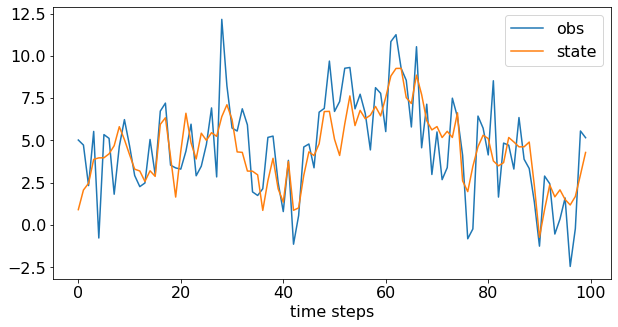

In [223]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size':16})
plt.plot(y)
plt.plot(x)
plt.xlabel('time steps')
plt.legend(['obs','state'])
plt.show()

# Latent state inference

Since we assume that we wont know the true model parameters, we'll use slightly different parameters for inference

In [224]:
params_2 = {'alpha': 0.5, 'beta': 0.4, 'delta':0., 'dt': 1, 'theta': 1, 'theta_0': 1. ,
         'sigma_x': 1., 'sigma_y': 6., 'K': 0.5, 'init_mu': 0., 'init_cov':20., 
           'prior_alpha_mu': 0., 'prior_alpha_var': -1., 'prior_beta_mu': 0.6, 'prior_beta_var': .1, 
           'prior_theta_mu': 0.9, 'prior_theta_var': .1, 'prior_theta0_mu': 0., 'prior_theta0_var': -2.}

 create particle filter

In [225]:
PF = BootstrapPF_withLLgradients(nparticles = 400, param_dict=params_2.copy(), 
                                 emission_model=emission_mean_func_,
                                 proposal_func=approximate_proposal,
                                 state_prior_func=simple_proposal,
                                 LL_grad_func=None,
                                 LL_func=emission_pdf_gauss,
                                 prior_grad_func=None,
                                 control_keys=['u','t','x_prev','y[t]'], 
                                 param_keys_update=['alpha','beta','theta','theta_0'],
                                 verbose=False, verbose_every=0)

In [14]:
%pdb

Automatic pdb calling has been turned ON


In [226]:
state_seqs, state_mean,_,w = PF.inference(y, u)

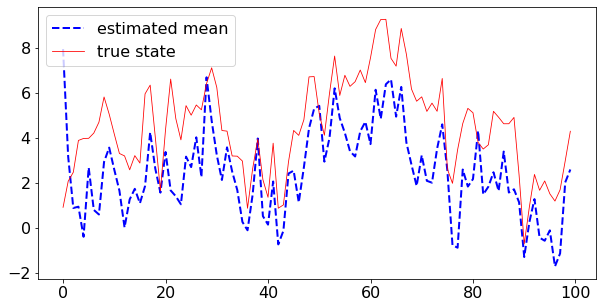

In [227]:
plt.figure(figsize=(10,5))
plt.plot(state_mean,'--b',lw=2.)
plt.plot(x,'r', lw = .8)
plt.legend(['estimated mean', 'true state'])
plt.show()

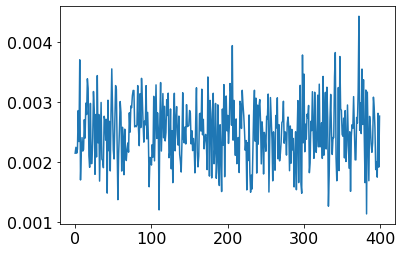

In [194]:
# weight distribution
plt.plot(w[-1])
plt.show()

# stochastic gradient lagevin for parameter optimization

We need to define the gradient functions

In [449]:
def likelihood_gradient_func(y, x, pdict, other):
    x_prev = other['x_prev'][other['i']]
    u_t = other['u'][other['t']]
    # proposal parameters
    inner_term = (x - (pdict['alpha']*x_prev + pdict['beta']*u_t))
    grad_alpha = inner_term * x_prev / pdict['sigma_x']**2
    grad_beta = inner_term * u_t / pdict['sigma_x']**2
    # emission parameters gradients
    # gradient of theta
    inner_term = (y - (pdict['theta']*np.exp(x) + pdict['theta_0']) )
    grad_theta = inner_term * np.exp(x) / pdict['sigma_y']**2
    grad_theta0 = inner_term / pdict['sigma_y']**2
    return grad_alpha, grad_beta, grad_theta, grad_theta0

def prior_grads_func(pdict):
    grad_alpha = loggauss_prior_grad(pdict['alpha'], pdict['prior_alpha_mu'], 
                                     pdict['prior_alpha_var'])
    grad_beta = loggauss_prior_grad(pdict['beta'], pdict['prior_beta_mu'], 
                                     pdict['prior_beta_var'])
    grad_theta = loggauss_prior_grad(pdict['theta'], pdict['prior_theta_mu'], 
                                     pdict['prior_theta_var'])
    grad_theta0 = loggauss_prior_grad(pdict['theta_0'], pdict['prior_theta0_mu'], 
                                     pdict['prior_theta0_var'])
    return grad_alpha, grad_beta, grad_theta, grad_theta0

inference with SGLD!

In [427]:
params_2 = {'alpha': 0.4, 'beta': 0.6, 'dt': 1, 'theta': .1, 'theta_0': 1. ,
         'sigma_x': 0.5, 'sigma_y': 4.,'init_mu': 0., 'init_cov':10., 
           'prior_alpha_mu': 0., 'prior_alpha_var': -1., 'prior_beta_mu': 0.6, 'prior_beta_var': .1, 
           'prior_theta_mu': 0.9, 'prior_theta_var': .1, 'prior_theta0_mu': 0., 'prior_theta0_var': -2.}

 create particle filter

In [487]:
PF = BootstrapPF_withLLgradients(nparticles = 200, param_dict=params_2.copy(), 
                                 emission_model=emission_mean_func_,
                                 proposal_func=linear_proposal_,
                                 LL_grad_func=likelihood_gradient_func,
                                 LL_func=emission_pdf_gauss,
                                 prior_grad_func=prior_grads_func,
                                 control_keys=['u','t','i','x_prev'], 
                                 param_keys_update=['alpha','beta','theta','theta_0'],
                                 verbose=False, verbose_every=0)

In [ ]:
state_seqs, state_mean = PF.fit_params(y, u, r = 0.01)

In [190]:
class BootstrapPF_withLLgradients(object):
    def __init__(self, ndim_state = 1, nparticles = 10, param_dict = pdict,
                 proposal_func = linear_proposal3,
                 LL_func = emission_pdf_gauss, 
                 emission_model = emission_meanfunc_proposal3,
                 state_prior_func = linear_proposal3,
                 LL_grad_func = None,
                 prior_grad_func = None,
                 param_keys_update = [],
                 control_keys = ['u','t','i','x_prev','yprev'],
                verbose = False, verbose_every = 10):
        
        self.N = nparticles
        self.control_args = {}
        for k in control_keys:
            self.control_args[k] = np.nan 
        self.ndim_state = ndim_state
        self.params_update = param_keys_update
        self.num_params = len(param_keys_update)
        self.pdict = param_dict
        self.proposal_func = proposal_func
        self.state_prior_func = state_prior_func
        self.emission_model = emission_model
        self.LL_func = LL_func
        self.compute_grads = False
        if LL_grad_func is not None:
            self.compute_grads = True
        self.LL_grad_func = LL_grad_func
        self.prior_grad_func = prior_grad_func
        self.verbose = verbose
        self.verbose_every = verbose_every
        
    def initialize_particles(self):
        return self.pdict['init_mu'] + self.pdict['init_cov'] * np.random.randn(self.N, self.ndim_state)
    
    def ancestor_resample(self, weights):
        ''' returns index of ancestors for each particle '''
        # for each particle, sample its ancestors based 
        # on the previous time step weights
        p = multinomial.rvs(n=1, p=weights, size=self.N)
        idx = p.argmax(axis=1)
        return idx
    
    def compute_unnorm_weights(self, x ,y, xprev):
        # data likelihood term
        LL_term = self.LL_func(y, x, self.emission_model, self.pdict, self.control_args)
        # state prior term
        prior_term = self.LL_func(x, xprev, self.state_prior_func, self.pdict, self.control_args)
        # proposal term (denominator)
        denom = self.LL_func(x, xprev, self.proposal_func, self.pdict, self.control_args)
        return (LL_term * prior_term) / denom
        
    def move_state_get_weights(self, prev_state, y):
        # sample next state from proposal
        x = self.proposal_func(prev_state, self.pdict, self.control_args)
        # compute likelhood for the current data point under each particle
        # and get unnormalized particle weights
        unnorm_weight = self.compute_unnorm_weights(x, y, prev_state)
        if self.compute_grads:
            # compute gradients of parameters 
            grads = self.LL_grad_func(y, x, self.pdict, self.control_args) 
        else:
            grads = None
        return x, unnorm_weight, grads
        
    def inference(self, y, u):
        ''' Sequential Importance Sampling with ancestor resampling
        
        '''
        # time steps
        T = len(y)
        # state of each particles [timesteps x Nparticles x state_dimension]
        x = np.zeros((T, self.N, self.ndim_state))
        ancestors = np.zeros((T, self.N), dtype='int')
        weights = np.zeros((T, self.N))
        
        # initialize weights
        weights0 = (1 / self.N) * np.ones(self.N)
        # initialize first state
        x0 = self.initialize_particles()
        if self.compute_grads:
            # cumulative gradients for parameters
            cumulative_grads = np.zeros((self.N, self.num_params))
        
        # loop over sequence, t indexes time 
        for t in range(T):
            start = time()
            # resample ancestors
            if t == 0:
                ancestors[t] = self.ancestor_resample(weights0)
            else:
                ancestors[t] = self.ancestor_resample(weights[t-1])
            
            # get previous state for all particles
            if t == 0:
                x_prev = x0[ancestors[t]]
            else:
                x_prev = x[t-1,ancestors[t]]
            
            # For each particle, get its new state, then compute its weights and gradients
            unnorm_weights = np.zeros(self.N)
            
            for i in range(self.N):
                for k in self.control_args.keys():
                    self.control_args[k] = eval(k)
                x[t,i], unnorm_weights[i], grads = self.move_state_get_weights(x_prev[i], y[t])
                # compute gradients of parameters
                if self.compute_grads:
                    for j in range(self.num_params):
                        cumulative_grads[i,j] = cumulative_grads[ancestors[t,i],j] + grads[j]
                # resample the path followed by the ith particle
                x[:t,i] = x[:t, ancestors[t,i]]
                
            # re-normalize weights
            if unnorm_weights.sum()==0 or np.any(np.isnan(weights[t-1])):
                pdb.set_trace()
            weights[t] = unnorm_weights / unnorm_weights.sum()
            
            
            if self.verbose and t%self.verbose_every==self.verbose_every-1:
                plt.figure(figsize=(15,4))
                #plt.bar(x=np.arange(len(weights[t])), height = weights[t], width = 0.8)
                plt.plot(np.arange(t), x_mu[:t])
                #plt.fill_between(np.arange(t), y1=x_var[:t].squeeze(), 
                #                 y2=-x_var[:t].squeeze(), alpha=0.4)
                plt.show()
                end = time()
                #print('Time step %d/%d, running LL : %.4f'%(t,T,running_ll))
                print('Time taken %.2f secs'%(end-start))
            
                     
        # done with iteration, get accumulated gradients
        if self.compute_grads:
            H = np.zeros(self.num_params)
            for j in range(self.num_params):
                H[j] = np.dot(weights[-1], cumulative_grads[:,j].squeeze())
        else:
            H = None
        # get posterior mean
        x_mu = np.dot(x.squeeze(), weights[-1])
        return x, x_mu, H, weights
    
    def init_learning_rate(self, n_iter, r = 0.01, g = 2., gamm = 0.9):
        tim = np.arange(n_iter)
        # eps is learning rate , decays exponentially in time
        # eps(t=0) is around 0.055
        eps = r * ((g + tim)**(-gamm))
        return eps
    
    def fit_params(self, y, controls, n_iter = 100, r = 0.005, g = 2., gamm = 0.9):
        ''' Do SGLD as outer loop and Particle Filtering as inner loop '''
        # learning rate decay 
        print('\n Starting SGLD with PF ')
        eps = self.init_learning_rate(n_iter, r, g, gamm)
        print('initial learning rate = %.4f \n'%(eps[0]))
        state_seqs = [None for _ in range(n_iter)]
        state_mean = [None for _ in range(n_iter)]
        for k in range(n_iter):
            # get state sequence, gradients by running particle filter O(N * T * ndim_state**2 time)
            state_seqs[k], state_mean[k], grad, w = self.inference(y, controls)
            e = entropy(w[-1], base=2)
            # get prior gradients
            prior_grad_list = self.prior_grad_func(self.pdict)
            prior_grads = np.array(prior_grad_list)
            all_steps = []
            for j, key in enumerate(self.params_update):
                stp = SGLD_step(grad[j], prior_grads[j], eps[k])
                all_steps.append(stp)
                self.pdict[key] += stp
            print('... Likelihood gradient norm = %.3f .....'%(np.linalg.norm(grad)))
            print('... Prior gradient norm = %.3f .....'%(np.linalg.norm(prior_grads)))
            print('... Step size norm = %.3f .... '%(np.linalg.norm(np.array(all_steps))))
            print('... Entropy of weights at last step (bits) = %.3f .....\n'%(e))
        return state_seqs, state_mean

In [ ]:
class VanillaParticlFilter(object):
    def __init__(self, ndim_state = 1, nparticles = 10, param_dict = pdict,
                 proposal_func = linear_proposal3,
                 LL_func = emission_pdf_gauss, 
                 emission_model = emission_meanfunc_proposal3,
                 state_prior_func = linear_proposal3,
                 LL_grad_func = None,
                 prior_grad_func = None,
                 param_keys_update = [],
                 control_keys = ['u','t','i','x_prev','yprev'],
                verbose = False, verbose_every = 10):
        
        self.N = nparticles
        self.control_args = {}
        for k in control_keys:
            self.control_args[k] = np.nan 
        self.ndim_state = ndim_state
        self.params_update = param_keys_update
        self.num_params = len(param_keys_update)
        self.pdict = param_dict
        self.proposal_func = proposal_func
        self.state_prior_func = state_prior_func
        self.emission_model = emission_model
        self.LL_func = LL_func
        self.compute_grads = False
        if LL_grad_func is not None:
            self.compute_grads = True
        self.LL_grad_func = LL_grad_func
        self.prior_grad_func = prior_grad_func
        self.verbose = verbose
        self.verbose_every = verbose_every
        
    def initialize_particles(self):
        return self.pdict['init_mu'] + self.pdict['init_cov'] * np.random.randn(self.N, self.ndim_state)
    
    def ancestor_resample(self, weights):
        ''' returns index of ancestors for each particle '''
        # for each particle, sample its ancestors based 
        # on the previous time step weights
        p = multinomial.rvs(n=1, p=weights, size=self.N)
        idx = p.argmax(axis=1)
        return idx
    
    def compute_unnorm_weights(self, x ,y, xprev):
        # data likelihood term
        LL_term = self.LL_func(y, x, self.emission_model, self.pdict, self.control_args)
        # state prior term
        prior_term = self.LL_func(x, xprev, self.state_prior_func, self.pdict, self.control_args)
        # proposal term (denominator)
        denom = self.LL_func(x, xprev, self.proposal_func, self.pdict, self.control_args)
        return (LL_term * prior_term) / denom
        
    def move_state_get_weights(self, prev_state, y):
        # sample next state from proposal
        x = self.proposal_func(prev_state, self.pdict, self.control_args)
        # compute likelhood for the current data point under each particle
        # and get unnormalized particle weights
        unnorm_weight = self.compute_unnorm_weights(x, y, prev_state)
        if self.compute_grads:
            # compute gradients of parameters 
            grads = self.LL_grad_func(y, x, self.pdict, self.control_args) 
        else:
            grads = None
        return x, unnorm_weight, grads
        
    def inference(self, y, u):
        ''' Sequential Importance Sampling with vanilla resampling
        
        '''
        # time steps
        T = len(y)
        # state of each particles [timesteps x Nparticles x state_dimension]
        x = np.zeros((T, self.N, self.ndim_state))
        ancestors = np.zeros((T, self.N), dtype='int')
        weights = np.zeros((T, self.N))
        
        # initialize weights
        weights0 = (1 / self.N) * np.ones(self.N)
        # initialize first state
        x0 = self.initialize_particles()
        if self.compute_grads:
            # cumulative gradients for parameters
            cumulative_grads = np.zeros((self.N, self.num_params))
        
        # place holder for previous observation value
        yprev = np.zeros(y.shape[-1])
        # loop over sequence, t indexes time 
        for t in range(T):
            start = time()
            # resample ancestors
            if t == 0:
                ancestors[t] = self.ancestor_resample(weights0)
            else:
                ancestors[t] = self.ancestor_resample(weights[t-1])
            # get previous state for all particles
            if t == 0:
                x_prev = x0[ancestors[t]]
            else:
                x_prev = x[t-1,ancestors[t]]
            
            # For each particle, get its new state, then compute its weights and gradients
            unnorm_weights = np.zeros(self.N)
            
            for i in range(self.N):
                for k in self.control_args.keys():
                    self.control_args[k] = eval(k)
                x[t,i], unnorm_weights[i], grads = self.move_state_get_weights(x_prev[i], y[t])
                # compute gradients of parameters
                if self.compute_grads:
                    for j in range(self.num_params):
                        cumulative_grads[i,j] = cumulative_grads[ancestors[t,i],j] + grads[j]
                        
            # re-normalize weights
            if unnorm_weights.sum()==0 or np.any(np.isnan(weights[t-1])):
                pdb.set_trace()
            weights[t] = unnorm_weights / unnorm_weights.sum()
            
            
            if self.verbose and t%self.verbose_every==self.verbose_every-1:
                plt.figure(figsize=(15,4))
                #plt.bar(x=np.arange(len(weights[t])), height = weights[t], width = 0.8)
                plt.plot(np.arange(t), x_mu[:t])
                #plt.fill_between(np.arange(t), y1=x_var[:t].squeeze(), 
                #                 y2=-x_var[:t].squeeze(), alpha=0.4)
                plt.show()
                end = time()
                #print('Time step %d/%d, running LL : %.4f'%(t,T,running_ll))
                print('Time taken %.2f secs'%(end-start))
            
            yprev = y[t]
            
        # done with iteration, get accumulated gradients
        if self.compute_grads:
            H = np.zeros(self.num_params)
            for j in range(self.num_params):
                H[j] = np.dot(weights[-1], cumulative_grads[:,j].squeeze())
        else:
            H = None
        # get posterior mean
        x_mu = np.dot(x.squeeze(), weights[-1])
        return x, x_mu, H, weights
    
    def init_learning_rate(self, n_iter, r = 0.01, g = 2., gamm = 0.9):
        tim = np.arange(n_iter)
        # eps is learning rate , decays exponentially in time
        # eps(t=0) is around 0.055
        eps = r * ((g + tim)**(-gamm))
        return eps
    
    def fit_params(self, y, controls, n_iter = 100, r = 0.005, g = 2., gamm = 0.9):
        ''' Do SGLD as outer loop and Particle Filtering as inner loop '''
        # learning rate decay 
        print('\n Starting SGLD with PF ')
        eps = self.init_learning_rate(n_iter, r, g, gamm)
        print('initial learning rate = %.4f \n'%(eps[0]))
        state_seqs = [None for _ in range(n_iter)]
        state_mean = [None for _ in range(n_iter)]
        for k in range(n_iter):
            # get state sequence, gradients by running particle filter O(N * T * ndim_state**2 time)
            state_seqs[k], state_mean[k], grad, w = self.inference(y, controls)
            e = entropy(w[-1], base=2)
            # get prior gradients
            prior_grad_list = self.prior_grad_func(self.pdict)
            prior_grads = np.array(prior_grad_list)
            all_steps = []
            for j, key in enumerate(self.params_update):
                stp = SGLD_step(grad[j], prior_grads[j], eps[k])
                all_steps.append(stp)
                self.pdict[key] += stp
            print('... Likelihood gradient norm = %.3f .....'%(np.linalg.norm(grad)))
            print('... Prior gradient norm = %.3f .....'%(np.linalg.norm(prior_grads)))
            print('... Step size norm = %.3f .... '%(np.linalg.norm(np.array(all_steps))))
            print('... Entropy of weights at last step (bits) = %.3f .....\n'%(e))
        return state_seqs, state_mean